In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [6]:
import os
from random import shuffle
from scipy.misc import imread
from tensorflow.contrib.keras.python.keras.utils import to_categorical

n_people = 38
n_train_person = 35

X_train = []
y_train = []
X_test = []
y_test = []

def is_legal_filename(fn):
    return len(fn) >= 24 and fn.endswith('.pgm')

for p in range(n_people):
    people_id = p + 1 + (p >= 13) * 1
    dirname = './CroppedYale/yaleB{:02}/'.format(people_id)
    filenames = [x for x in os.listdir(dirname) if is_legal_filename(x)]
    shuffle(filenames)
            
    for filename in filenames[:n_train_person]:
        img = imread(dirname + filename, mode='F').reshape((192, 168, 1))
        X_train.append(img)
        y_train.append(p)
    
    for filename in filenames[n_train_person:]:
        img = imread(dirname + filename, mode='F').reshape((192, 168, 1))
        X_test.append(img)
        y_test.append(p)
        
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.int32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.int32)

y_train = to_categorical(y_train, num_classes=n_people)
y_test = to_categorical(y_test, num_classes=n_people)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1330, 192, 168, 1) (1330, 38)
(1084, 192, 168, 1) (1084, 38)


In [7]:
from tensorflow.contrib.keras.python.keras.preprocessing.image import ImageDataGenerator

std = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
std.fit(X_train)
X_train = std.standardize(X_train)
X_test = std.standardize(X_test)

In [8]:
# from keras.models import Sequential
# from keras.layers import *
# from keras.optimizers import SGD

from tensorflow.contrib.keras.python.keras.models import Sequential
from tensorflow.contrib.keras.python.keras.layers import *
from tensorflow.contrib.keras.python.keras.optimizers import SGD

model = Sequential()
model.add(Conv2D(8, kernel_size=(11, 11), activation='relu', input_shape=(192, 168, 1)))
model.add(Conv2D(16, kernel_size=(9, 9), activation='relu'))
model.add(Conv2D(32, kernel_size=(7, 7)))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(32, kernel_size=(5, 5)))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Flatten())
model.add(Dense(512))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(Dense(38, activation='softmax'))

sgd = SGD(lr=0.001, decay=0.01, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=10, epochs=10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 182, 158, 8)       976       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 174, 150, 16)      10384     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 168, 144, 32)      25120     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 48, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 52, 44, 32)        25632     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 17, 14, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 7616)              0         
__________

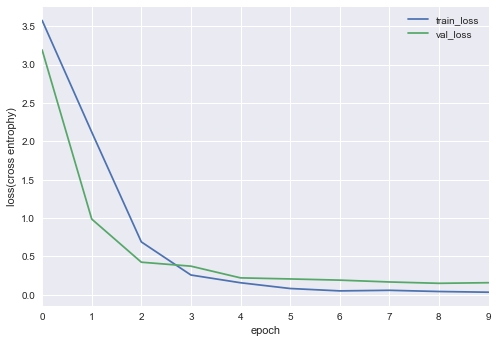

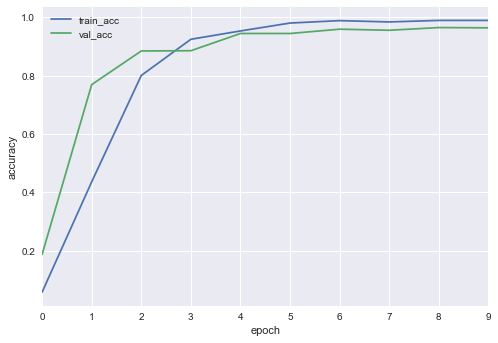

In [10]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame()
df['train_loss'] = hist.history['loss']
df['val_loss'] = hist.history['val_loss']
ax = df.plot(kind='line')
ax.set_xlabel('epoch')
ax.set_ylabel('loss(cross entrophy)')

df = pd.DataFrame()
df['train_acc'] = hist.history['acc']
df['val_acc'] = hist.history['val_acc']
ax = df.plot(kind='line')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')